In [1]:
# imports
import os
os.sys.path.append(os.path.abspath(".."))

import random

from copy import deepcopy

import pandas as pd
import numpy as np

import keras

from matplotlib import pyplot as plt

import json

import notebooks_utils.analysis as utils

from IPython.display import display

import project.download_content as content

METAPATH = os.path.join(content.DATAPATH, 'METADATA')

from notebooks_utils.visuals import draw_bbox

Using TensorFlow backend.


## Loading data

Inspired in the EDA notebook inside this project
http://htmlpreview.github.io/?https://github.com/BAlmeidaS/capstone-udacity-mle/blob/master/EDA.html

### Loading data

In [2]:
# metadata general files
df_classes_raw = pd.read_csv(METAPATH + "/class-descriptions-boxable.csv",
                         names=['class_encode', 'class_name'])
with open(METAPATH + "/bbox_labels_600_hierarchy.json") as f:
    dict_hierarchy_raw = json.load(f)
    
df_train_raw = (pd.read_csv(METAPATH + "/train-annotations-bbox.csv")
                  .merge(utils.images_downloaded('TRAIN'),
                         on='ImageID', how='inner')
                  .merge(df_classes_raw, left_on='LabelName', right_on='class_encode',
                         how='left')
                  .drop(columns=['class_encode'])
                  .rename(columns={'class_name': 'LabelSemantic'}))
df_val_raw = (pd.read_csv(METAPATH + "/validation-annotations-bbox.csv")
                .merge(utils.images_downloaded('VALIDATION'),
                       on='ImageID', how='inner')
                .merge(df_classes_raw, left_on='LabelName', right_on='class_encode',
                       how='left')
                .drop(columns=['class_encode'])
                .rename(columns={'class_name': 'LabelSemantic'}))
df_test_raw = (pd.read_csv(METAPATH + "/test-annotations-bbox.csv")
                 .merge(utils.images_downloaded('TEST'),
                         on='ImageID', how='inner')
                 .merge(df_classes_raw, left_on='LabelName', right_on='class_encode',
                        how='left')
                 .drop(columns=['class_encode'])
                 .rename(columns={'class_name': 'LabelSemantic'}))

In [3]:
df_train_raw.head(2)

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,Path,LabelSemantic
0,000002b66c9c498e,xclick,/m/01g317,1,0.0125,0.195312,0.148438,0.587500,0,1,0,0,0,data/TRAIN/train_0/000002b66c9c498e.jpg,Person
1,000002b66c9c498e,xclick,/m/01g317,1,0.0250,0.276563,0.714063,0.948438,0,1,0,0,0,data/TRAIN/train_0/000002b66c9c498e.jpg,Person


### Wrangling

In [4]:
# cleaning
df_train_raw = df_train_raw.drop_duplicates()
df_val_raw = df_val_raw.drop_duplicates()
df_test_raw = df_test_raw.drop_duplicates()

In [5]:
# creating a hierarchical dict with semantic labels
def changing_to_semantic(tree, *args):
    try:
        tree['LabelName'] = utils.semantic_name(tree['LabelName'])
    except KeyError:
        tree['LabelName'] = 'Entity'
    
    if 'Subcategory' in tree.keys():
        for subcat in tree['Subcategory']:
            changing_to_semantic(subcat, *args, tree['LabelName'])
            
dict_hierarchy = deepcopy(dict_hierarchy_raw)
changing_to_semantic(dict_hierarchy)

In [6]:
#adding label to the first node
df_encodes = pd.concat([pd.DataFrame([['/m/0bl9f', 'Entity']],
                                     columns=['class_encode', 'class_name']),
                        df_classes_raw],
                       ignore_index=True)

In [7]:
# creating a df to show in a tabular form the relation between classes
df_hierarchy = pd.DataFrame(utils.tabularize_hierarchy_dict(dict_hierarchy,
                                                            df_encodes),
                            columns=['Id', 'Label', 'IdParent',
                                     'LabelParent', 'Depth', 'Leaf'])


In [8]:
# creating a classes df
df_classes = (df_hierarchy.merge(df_encodes, left_on='Label', right_on='class_name')
                          .drop(columns=['class_name'])
                          .rename(columns={'class_encode': 'Encode'})
                          .merge(df_encodes, left_on='LabelParent', right_on='class_name')
                          .drop(columns=['class_name'])
                          .rename(columns={'class_encode': 'EncodeParent'})
                          [['Id', 'Label', 'Encode',
                            'IdParent', 'LabelParent', 'EncodeParent',
                            'Depth', 'Leaf']])

### Visualize DFs

In [9]:
display(df_train_raw.head(2))
display(df_val_raw.head(2))
display(df_test_raw.head(2))
display(df_classes.head(2))

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,Path,LabelSemantic
0,000002b66c9c498e,xclick,/m/01g317,1,0.0125,0.195312,0.148438,0.587500,0,1,0,0,0,data/TRAIN/train_0/000002b66c9c498e.jpg,Person
1,000002b66c9c498e,xclick,/m/01g317,1,0.0250,0.276563,0.714063,0.948438,0,1,0,0,0,data/TRAIN/train_0/000002b66c9c498e.jpg,Person


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,Path,LabelSemantic
0,0001eeaf4aed83f9,xclick,/m/0cmf2,1,0.022673,0.9642,0.071038,0.800546,0,0,0,0,0,data/VALIDATION/validation/0001eeaf4aed83f9.jpg,Airplane
1,000595fe6fee6369,xclick,/m/02wbm,1,0.000000,1.0000,0.000000,1.000000,0,0,1,0,0,data/VALIDATION/validation/000595fe6fee6369.jpg,Food


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,Path,LabelSemantic
0,000026e7ee790996,xclick,/m/07j7r,1,0.071875,0.145313,0.206250,0.391667,0,1,1,0,0,data/TEST/test/000026e7ee790996.jpg,Tree
1,000026e7ee790996,xclick,/m/07j7r,1,0.439063,0.571875,0.264583,0.435417,0,1,1,0,0,data/TEST/test/000026e7ee790996.jpg,Tree


,Id,Label,Encode,IdParent,LabelParent,EncodeParent,Depth,Leaf
0,132,Coin,/m/0242l,0,Entity,/m/0bl9f,1,True
1,211,Flag,/m/03120,0,Entity,/m/0bl9f,1,True


### Preprocess data

In [10]:
%%time
for df in [df_train_raw, df_val_raw, df_test_raw]:
    df['cx'] = ((df.XMax - df.XMin) / 2) + df.XMin
    df['cy'] = ((df.YMax - df.YMin) / 2) + df.YMin
    df['w'] = df.XMax - df.XMin
    df['h'] = df.YMax - df.YMin

CPU times: user 1.1 s, sys: 627 ms, total: 1.73 s
Wall time: 381 ms


In [11]:
r = df_train_raw.sample(1, random_state=43).iloc[0]
r

ImageID                                 18fbecb9ecfdb891
Source                                            xclick
LabelName                                       /m/0dzct
Confidence                                             1
XMin                                             0.58625
XMax                                            0.763125
YMin                                            0.266667
YMax                                            0.610833
IsOccluded                                             1
IsTruncated                                            0
IsGroupOf                                              0
IsDepiction                                            0
IsInside                                               0
Path             data/TRAIN/train_1/18fbecb9ecfdb891.jpg
LabelSemantic                                 Human face
cx                                              0.674688
cy                                               0.43875
w                              

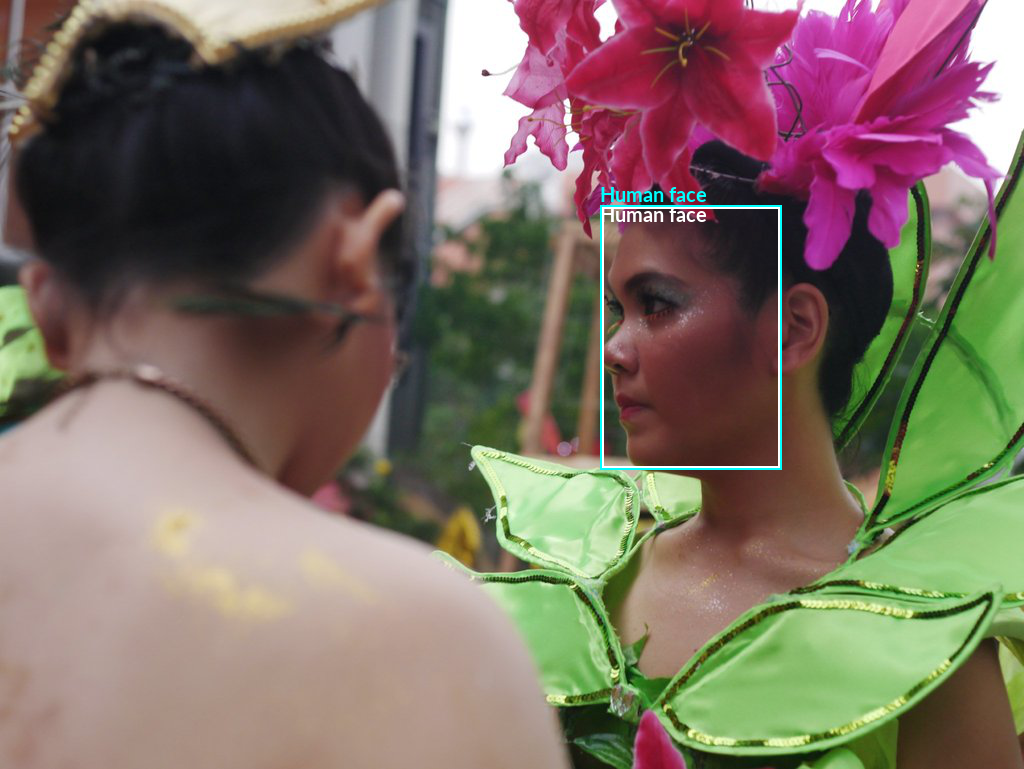

In [12]:
from keras.preprocessing import image
from PIL import ImageDraw, ImageFont

font_path = "/usr/share/fonts/truetype/lato/Lato-Bold.ttf"
font = ImageFont.truetype(font_path, size=20)

img_path = r.Path

img = image.load_img(img_path)

draw = ImageDraw.Draw(img)

# WHITE
# drawing the bounding box with default params
draw.rectangle((r.XMin * img.size[0], r.YMin * img.size[1],
                r.XMax * img.size[0], r.YMax * img.size[1]),
               width=4, outline="#ffffff")

draw.text((r.XMin * img.size[0], r.YMin * img.size[1]),
          r.LabelSemantic, font=font, fill=(255,255,255))

# BLUE
# drawing bounding box based on the center of it
draw.rectangle((((r.cx - r.w/2) * img.size[0],
                 (r.cy - r.h/2) * img.size[1]),
                ((r.cx + r.w/2) * img.size[0],
                 (r.cy + r.h/2) * img.size[1])),
               width=2, outline=(0, 255, 255))

draw.text(((r.cx - r.w/2) * img.size[0], (r.cy - r.h/2) * img.size[1] - 20),
          r.LabelSemantic, font=font, fill=(0, 255, 255))

img

In [13]:
%%time
# df_train = df_train_raw.groupby('ImageID')[['Path']].last()

# for col in ['XMin', 'XMax', 'YMin', 'YMax']:
#     df_train = df_train.join(df_train_raw.groupby('ImageID')
#                                          [col]
#                                          .apply(list))
                     
# df_train.head(2)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [14]:
%%time
# df_train = df_train_raw.groupby('ImageID')[['Path']].last()

# for col in ['XMin', 'XMax', 'YMin', 'YMax']:
#     keys, values = df_train_raw[['ImageID', col]].sort_values('ImageID').values.T
#     ukeys, index = np.unique(keys, True)
#     arrays = np.split(values, index[1:])
#     df_train = df_train.join(pd.DataFrame({'ImageID': ukeys,
#                                            col:[list(a) for a in arrays]})
#                                .set_index('ImageID'))

# df_train.head(2)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs


In [15]:
%%time
df_train_raw.to_csv(METAPATH + "/enriched_train_bbox.csv", index=False)
df_val_raw.to_csv(METAPATH + "/enriched_val_bbox.csv", index=False)
df_test_raw.to_csv(METAPATH + "/enriched_test_bbox.csv", index=False)

CPU times: user 2min 39s, sys: 1.6 s, total: 2min 40s
Wall time: 2min 41s
